# Example codes: finite DMRG
Please look at the [readme page](https://www.tensors.net/code)if you have not done so already. Here, we present an implementation of the density matrix renormalization group (DMRG) algorithm to solve the ground state of a finite 1D quantum system with open boundary conditions. We present two versions of the code: the first requires the Hamiltonian to be expressed as an [MPO](https://arxiv.org/abs/0804.3976) and the second requires the Hamiltonian to be expressed as a sum of nearest neighbor two-body terms. By convention we set the number of tensors in the MPS to be the same as the number of lattice sites, such that the first and last MPS tensor have a trivial (dim 1) index on the left and right respectively. We enforce the MPS tensors to be orthonormal, where 'A' denote left orthogonal tensors and 'B' denote right orthogonal tensors. These 'A' and 'B' tensors are stored separately, such that any center of orthogonality can be realized without additional manipulation of the MPS tensors.

    
#### Summary
- Computational cost: O(χ^3)

- Finite open chain

- Utilizes orthonormal form of MPS tensors 


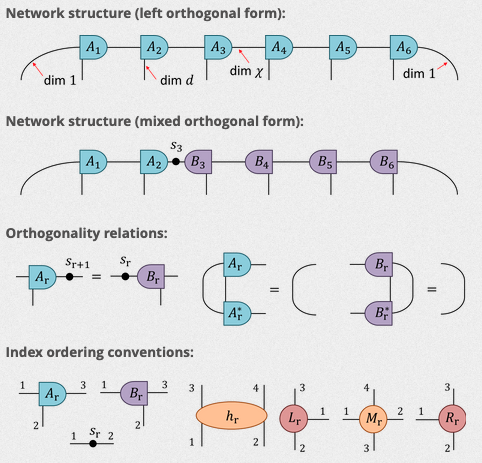

## MPO version of DMRG
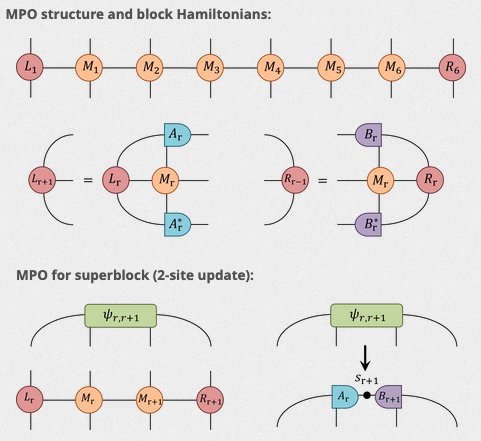

In [3]:
def doApplyMPO(psi,L,M1,M2,R):
    """ function for applying MPO to state """
    
    return ncon([psi.reshape(L.shape[2],M1.shape[3],M2.shape[3],R.shape[2]),L,M1,M2,R],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               L.shape[2]*M1.shape[3]*M2.shape[3]*R.shape[2]);

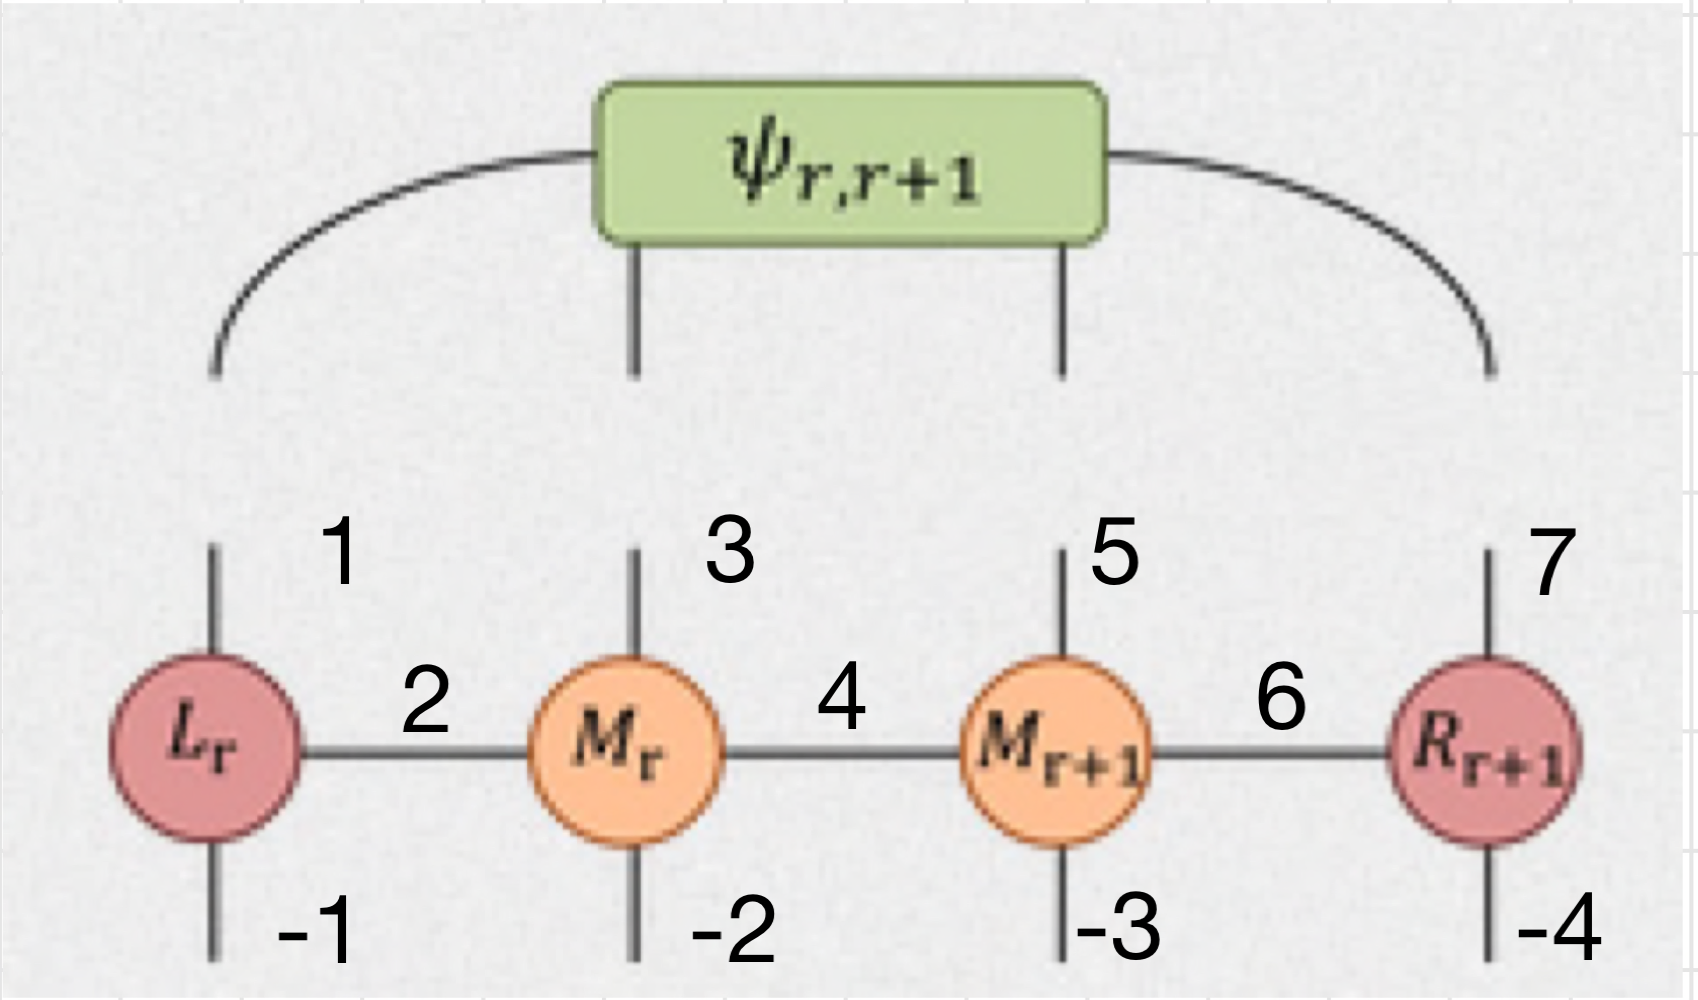

In [4]:

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval

In [5]:
def Left_orthogonal(A, L, M):
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    return A, L, sWeight

In [42]:
# -*- coding: utf-8 -*-
# doDMRG_MPO.py
import numpy as np
from numpy import linalg as LA
from ncon import ncon

def doDMRG_MPO(A,ML,M,MR,chi, numsweeps = 10,  maxit = 2, krydim = 4):
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""

    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = M.shape[2] #local dimension
    Nsites = len(A)
    L = [0 for x in range(Nsites)]; L[0] = ML
    R = [0 for x in range(Nsites)]; R[Nsites-1] = MR
    A, L, sWeight =Left_orthogonal(A, L, M)
    
    Ekeep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            
            ##### update-tensor
            psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
            Ekeep = np.append(Ekeep,Entemp)
            
            ##### decompose two-site operator to create new A, B, R
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            R[p] = ncon([M,R[p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
            Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        print('Sweep: %d of %d, Energy: %12.12d, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            
    return Ekeep, A, sWeight, B

Sweep: 1 of 4, Energy: -000000000062, Bond dim: 16
Sweep: 2 of 4, Energy: -000000000062, Bond dim: 16
Sweep: 3 of 4, Energy: -000000000062, Bond dim: 16
Sweep: 4 of 4, Energy: -000000000062, Bond dim: 16
Sweep: 5 of 4, Energy: -000000000062, Bond dim: 16
Sweep: 1 of 4, Energy: -000000000062, Bond dim: 32
Sweep: 2 of 4, Energy: -000000000062, Bond dim: 32
Sweep: 3 of 4, Energy: -000000000062, Bond dim: 32
Sweep: 4 of 4, Energy: -000000000062, Bond dim: 32
Sweep: 5 of 4, Energy: -000000000062, Bond dim: 32


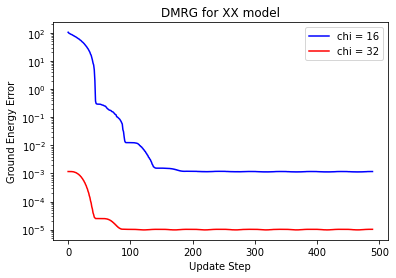

In [43]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

#### Preamble
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

from ncon import ncon

##### Example 1: XX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16;
Nsites = 50;

OPTS_numsweeps = 4 # number of DMRG sweeps
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

#### Define Hamiltonian MPO (quantum XX model)
chid = 2
sP = np.sqrt(2)*np.array([[0, 0],[1, 0]])
sM = np.sqrt(2)*np.array([[0, 1],[0, 0]])
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0,-1]])
sI = np.array([[1, 0], [0, 1]])
M = np.zeros([4,4,chid,chid]);
M[0,0,:,:] = sI; M[3,3,:,:] = sI
M[0,1,:,:] = sM; M[1,3,:,:] = sP
M[0,2,:,:] = sP; M[2,3,:,:] = sM
ML = np.array([1,0,0,0]).reshape(4,1,1) #left MPO boundary
MR = np.array([0,0,0,1]).reshape(4,1,1) #right MPO boundary

#### Initialize MPS tensors
A = [0 for x in range(Nsites)]
A[0] = np.random.rand(1,chid,min(chi,chid))
for k in range(1,Nsites):
    A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(Nsites-k-1)))

#### Do DMRG sweeps (2-site approach)
En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, 
                                maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Increase bond dim and reconverge
chi = 32;
En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, 
                                maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Compare with exact results (computed from free fermions)
H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

##### Plot results
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(En1)), En1 - EnExact, 'b', label="chi = 16")
plt.plot(range(len(En2)), En2 - EnExact, 'r', label="chi = 32")
plt.legend()
plt.title('DMRG for XX model')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()

#### Compute 2-site reduced density matrices, local energy profile
rhotwo = [0 for x in range(Nsites-1)]
hamloc = (np.real(np.kron(sX,sX) + np.kron(sY,sY))).reshape(2,2,2,2)
Enloc = np.zeros(Nsites-1)
for k in range(Nsites-1):
    rhotwo[k] = ncon([A[k],np.conj(A[k]),A[k+1],np.conj(A[k+1]),sWeight[k+2],
                     sWeight[k+2]],[[1,-3,2],[1,-1,3],[2,-4,4],[3,-2,5],[4,6],[5,6]])
    Enloc[k] = ncon([hamloc,rhotwo[k]],[[1,2,3,4],[1,2,3,4]])